## STAGE 1: LIBRARY IMPORTS AND SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## STAGE 2: CLASS DEFINITION AND METHODS

In [ ]:
class MNISTDigitRecognizer:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.history = None

    def load_and_preprocess_data(self, train_path, test_path=None):
        print("Loading training dataset...")
        train_data = pd.read_csv(train_path)
        y_train = train_data['label'].values
        X_train = train_data.drop('label', axis=1).values
        # Reshape the data to 28x28 images
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_train = X_train.astype('float32') / 255.0
        y_train_categorical = keras.utils.to_categorical(y_train, 10)
        print(f"Training dataset shape: {X_train.shape}")
        print(f"Training labels shape: {y_train_categorical.shape}")
        X_test, y_test, y_test_categorical = None, None, None
        if test_path is not None:
            print("Loading test dataset...")
            test_data = pd.read_csv(test_path)
            X_test = test_data.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0
            y_test, y_test_categorical = None, None
            print(f"Test dataset shape: {X_test.shape}")
        return X_train, y_train, y_train_categorical, X_test, y_test, y_test_categorical
    
    def visualize_samples(self, X, y, num_samples=10):
        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow(X[i].reshape(28, 28), cmap='gray')
            plt.title(f'Label: {y[i]}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    def build_cnn_model(self):
            model = keras.Sequential([
                # First Convolutional Block
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
                layers.BatchNormalization(),
                layers.Conv2D(32, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Dropout(0.25),

                # Second Convolutional Block
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Dropout(0.25),

                # Third Convolutional Block
                layers.Conv2D(128, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.25),

                # Fully Connected Layers
                layers.Flatten(),
                layers.Dense(512, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.5),
                layers.Dense(256, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(10, activation='softmax')
            ])
            return model

    def build_mlp_model(self):
            model = keras.Sequential([
                layers.Flatten(input_shape=(28, 28, 1)),
                layers.Dense(512, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.3),
                layers.Dense(256, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.3),
                layers.Dense(128, activation='relu'),
                layers.Dropout(0.3),
                layers.Dense(10, activation='softmax')
            ])

            return model

    def compile_and_train(self, X_train, y_train, X_val, y_val, model_type='cnn', epochs=30, batch_size=128):
            print(f"Building {model_type.upper()} model...")

            if model_type.lower() == 'cnn':
                self.model = self.build_cnn_model()
            else:
                self.model = self.build_mlp_model()

            self.model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            self.model.summary()

            callbacks = [
                keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,
                    restore_best_weights=True,
                    verbose=1
                ),
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=3,
                    min_lr=1e-7,
                    verbose=1
                )
            ]

            print("Training model...")
            self.history = self.model.fit(
                X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                verbose=1
            )
            return self.history
        
    def plot_training_history(self):
            if self.history is None:
                print("No training history available!")
                return
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
            ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
            ax1.set_title('Model Accuracy')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Accuracy')
            ax1.legend()
            ax1.grid(True)
            ax2.plot(self.history.history['loss'], label='Training Loss')
            ax2.plot(self.history.history['val_loss'], label='Validation Loss')
            ax2.set_title('Model Loss')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.legend()
            ax2.grid(True)
            plt.tight_layout()
            plt.show()

    def evaluate_model(self, X_test, y_test, y_test_categorical):
            if self.model is None:
                print("No trained model available!")
                return
            print("Making predictions...")
            y_pred_proba = self.model.predict(X_test)
            y_pred = np.argmax(y_pred_proba, axis=1)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()
            return accuracy, y_pred, y_pred_proba

    def visualize_predictions(self, X_test, y_test, y_pred, num_samples=10):
            plt.figure(figsize=(15, 8))
            for i in range(num_samples):
                plt.subplot(2, 5, i + 1)
                plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
                plt.title(f'True: {y_test[i]}, Pred: {y_pred[i]}')
                if y_test[i] != y_pred[i]:
                    plt.title(f'True: {y_test[i]}, Pred: {y_pred[i]}', color='red')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
    
    def predict_single_image(self, image):
            if self.model is None:
                print("No trained model available!")
                return None
            if len(image.shape) == 2:
                image = image.reshape(1, 28, 28, 1)
            elif len(image.shape) == 3:
                image = image.reshape(1, 28, 28, 1)
            if image.max() > 1:
                image = image / 255.0
            prediction = self.model.predict(image)
            predicted_digit = np.argmax(prediction)
            confidence = prediction[0][predicted_digit]
            return predicted_digit, confidence

## STAGE 3: INITIALIZE RECOGNIZER AND LOAD DATA

In [3]:
recognizer = MNISTDigitRecognizer()

train_path = r'E:\AI\UneeQ Intern\5. Handwritten Digit Recognition using Deep Learning\train.csv'
test_path = r'E:\AI\UneeQ Intern\5. Handwritten Digit Recognition using Deep Learning\test.csv'

X_train_full, y_train_full, y_train_full_cat, X_test_competition, y_test_competition, y_test_competition_cat = recognizer.load_and_preprocess_data(train_path, test_path)

Loading training dataset...
Training dataset shape: (42000, 28, 28, 1)
Training labels shape: (42000, 10)
Loading test dataset...
Test dataset shape: (28000, 28, 28, 1)


## STAGE 4: DATA SPLITTING AND PREPARATION

In [4]:
print("Splitting training data...")
X_train, X_val, y_train, y_val, y_train_cat, y_val_cat = train_test_split(
    X_train_full, y_train_full, y_train_full_cat, 
    test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Competition test set size: {X_test_competition.shape[0]}")

Splitting training data...
Training set size: 33600
Validation set size: 8400
Competition test set size: 28000


## STAGE 5: DATA VISUALIZATION

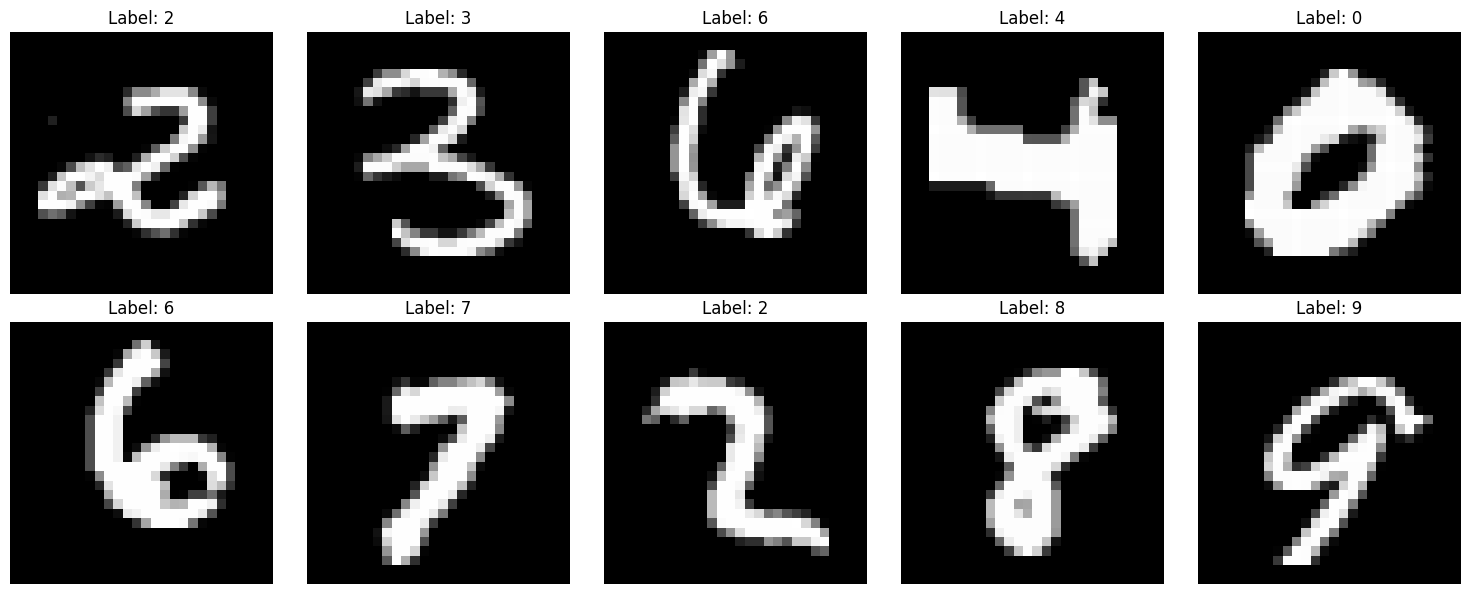

In [ ]:
recognizer.visualize_samples(X_train, y_train)

## STAGE 6: MODEL TRAINING

In [6]:
history = recognizer.compile_and_train(
    X_train, y_train_cat, X_val, y_val_cat, 
    model_type='cnn', epochs=12, batch_size=128
)

Building CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,346 (2.05 MB)

 Trainable params: 536,874 (2.05 MB)

 Non-trainable params: 1,472 (5.75 KB)

Training model...
Epoch 1/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.6369 - loss: 1.3087 - val_accuracy: 0.1115 - val_loss: 7.7212 - learning_rate: 0.0010
Epoch 2/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9516 - loss: 0.1624 - val_accuracy: 0.8943 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 3/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9654 - loss: 0.1157 - val_accuracy: 0.9836 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 4/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9744 - loss: 0.0833 - val_accuracy: 0.9865 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 5/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9772 - loss: 0.0738 - val_accuracy: 0.9873 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 6/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9821 - loss: 0.0600 - val_accuracy: 0.9882 - val_loss: 0.0406 - learning_rate: 0.0010
Epoch 7/12
263/263 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - ac

## STAGE 7: TRAINING HISTORY VISUALIZATION

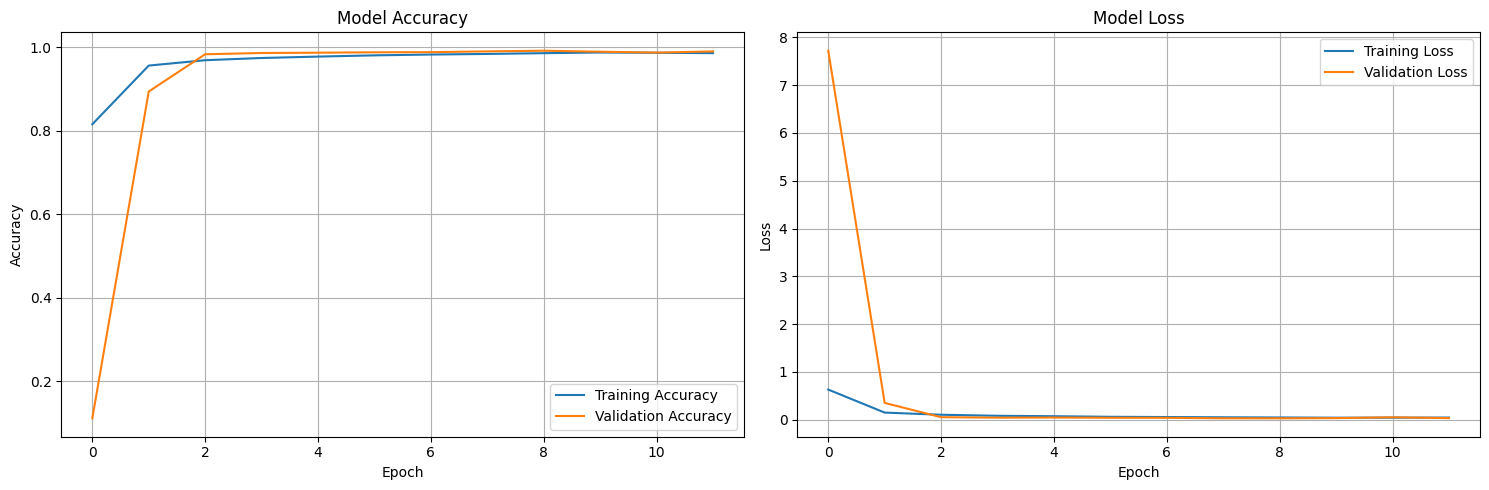

In [7]:
recognizer.plot_training_history()

## STAGE 8: MODEL EVALUATION

Making predictions...
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Accuracy: 0.9920

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       827
           1       1.00      0.99      0.99       937
           2       0.99      0.99      0.99       835
           3       1.00      0.99      0.99       870
           4       0.99      0.99      0.99       814
           5       0.99      0.99      0.99       759
           6       1.00      0.99      0.99       827
           7       0.99      1.00      0.99       880
           8       0.99      0.99      0.99       813
           9       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



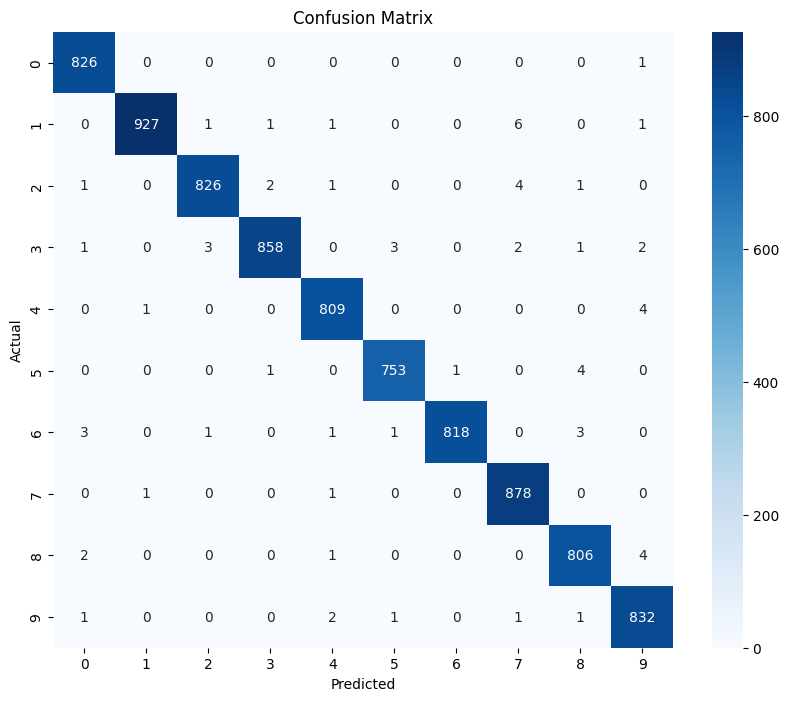

In [8]:
accuracy, y_pred, y_pred_proba = recognizer.evaluate_model(X_val, y_val, y_val_cat)

## STAGE 9: PREDICTION VISUALIZATION

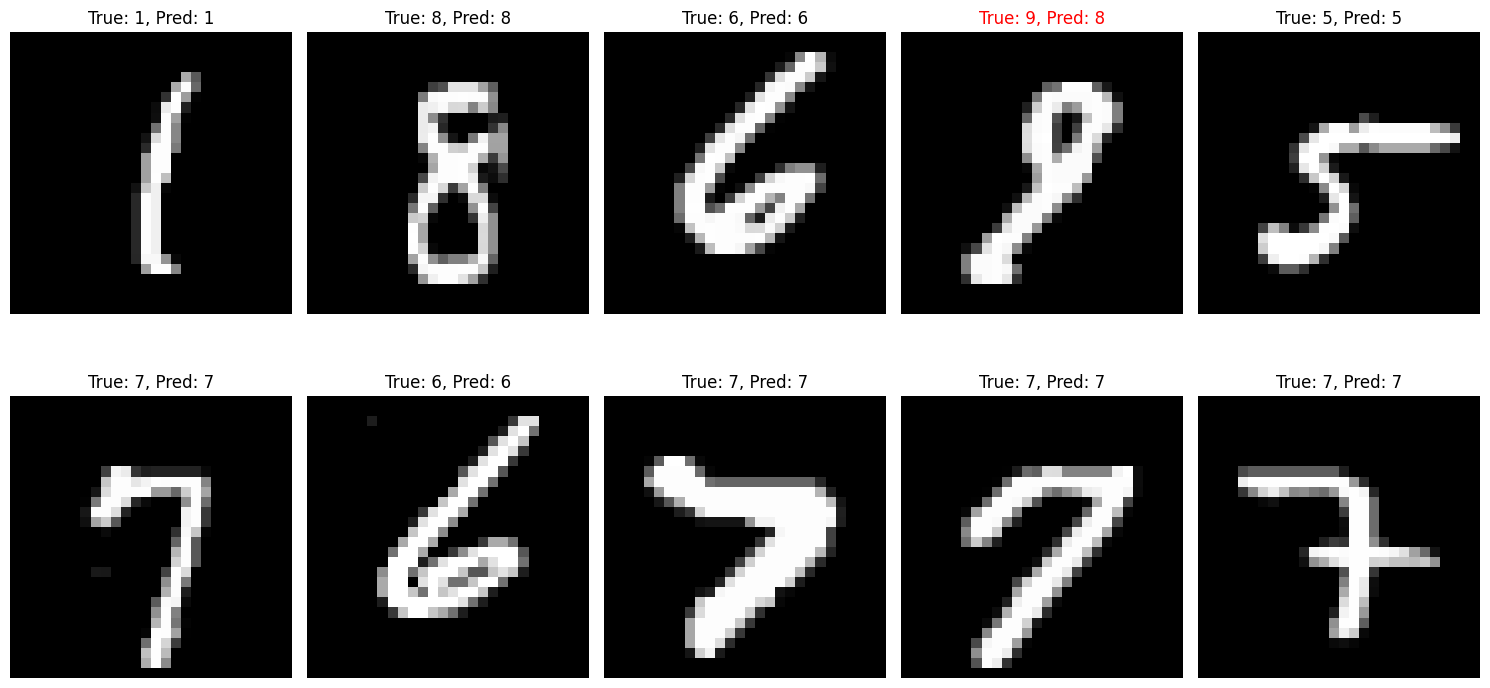

In [ ]:
recognizer.visualize_predictions(X_val, y_val, y_pred)

## STAGE 10: MODEL SAVING

In [10]:
accuracy_pct = int(accuracy * 10000) / 100
model_filename = f'mnist_digit_recognizer_acc_{accuracy_pct:.2f}.h5'
recognizer.model.save(model_filename)
print(f"Model saved as '{model_filename}' with accuracy {accuracy_pct:.2f}%")

Model saved as 'mnist_digit_recognizer_acc_99.20.h5' with accuracy 99.20%


## STAGE 11: QUICK TESTING FUNCTION

In [11]:
def quick_test():
    indices = np.random.choice(len(X_val), 5, replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        pred_digit, confidence = recognizer.predict_single_image(X_val[idx])
        plt.subplot(1, 5, i+1)
        plt.imshow(X_val[idx].reshape(28, 28), cmap='gray')
        plt.title(f'True: {y_val[idx]}\nPred: {pred_digit}\nConf: {confidence:.3f}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


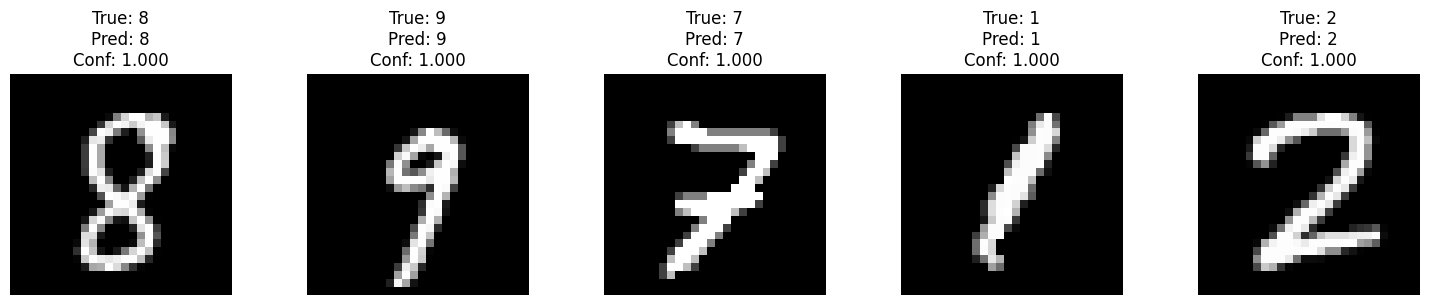

In [12]:
quick_test()

## STAGE 12: LOADING SAVED MODEL FOR TESTING

In [14]:
model = keras.models.load_model("mnist_digit_recognizer_acc_99.20.h5")
csv_file_path = r'E:\AI\UneeQ Intern\5. Handwritten Digit Recognition using Deep Learning\train.csv'
df = pd.read_csv(csv_file_path)

X = df.drop('label', axis=1).values.astype('float32') / 255.0
y = df['label'].values
X = X.reshape(-1, 28, 28, 1)

In [15]:
def test_single_image():
    idx = np.random.randint(0, len(X))
    sample_image = X[idx]
    true_label = y[idx]
    
    prediction = model.predict(sample_image.reshape(1,28,28,1), verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    color = 'green' if predicted_class == true_label else 'red'
    plt.figure(figsize=(6, 4))
    plt.imshow(sample_image.reshape(28,28), cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_class}\nConfidence: {confidence:.3f}", color=color, fontsize=12)
    plt.axis("off")
    plt.show()
    
    if predicted_class == true_label:
        print(f"✅ Correct! Predicted {predicted_class} with {confidence:.1%} confidence")
    else:
        print(f"❌ Wrong! True: {true_label}, Predicted: {predicted_class} ({confidence:.1%} confidence)")

In [16]:
def test_multiple_images(num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()
    
    correct = 0
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        sample_image = X[idx]
        true_label = y[idx]
        
        prediction = model.predict(sample_image.reshape(1,28,28,1), verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = prediction[0][predicted_class]
        
        axes[i].imshow(sample_image.reshape(28,28), cmap='gray')
        color = 'green' if predicted_class == true_label else 'red'
        axes[i].set_title(f"T:{true_label} P:{predicted_class}\n{confidence:.2f}", 
                         color=color, fontsize=10)
        axes[i].axis('off')
        
        if predicted_class == true_label:
            correct += 1
    
    plt.tight_layout()
    plt.suptitle(f'Test Results: {correct}/{num_images} Correct ({correct/num_images*100:.1f}%)', 
                 y=1.02, fontsize=14)
    plt.show()
    
    print(f"Accuracy: {correct}/{num_images} = {correct/num_images*100:.1f}%")

 Testing Single Image 


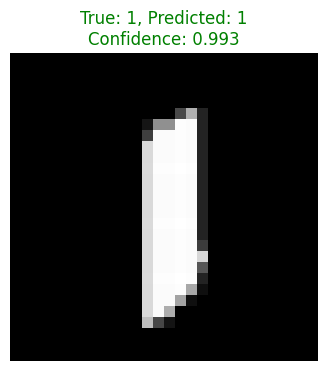

✅ Correct! Predicted 1 with 99.3% confidence


In [28]:
print(" Testing Single Image ")
test_single_image()

Testing Multiple Images


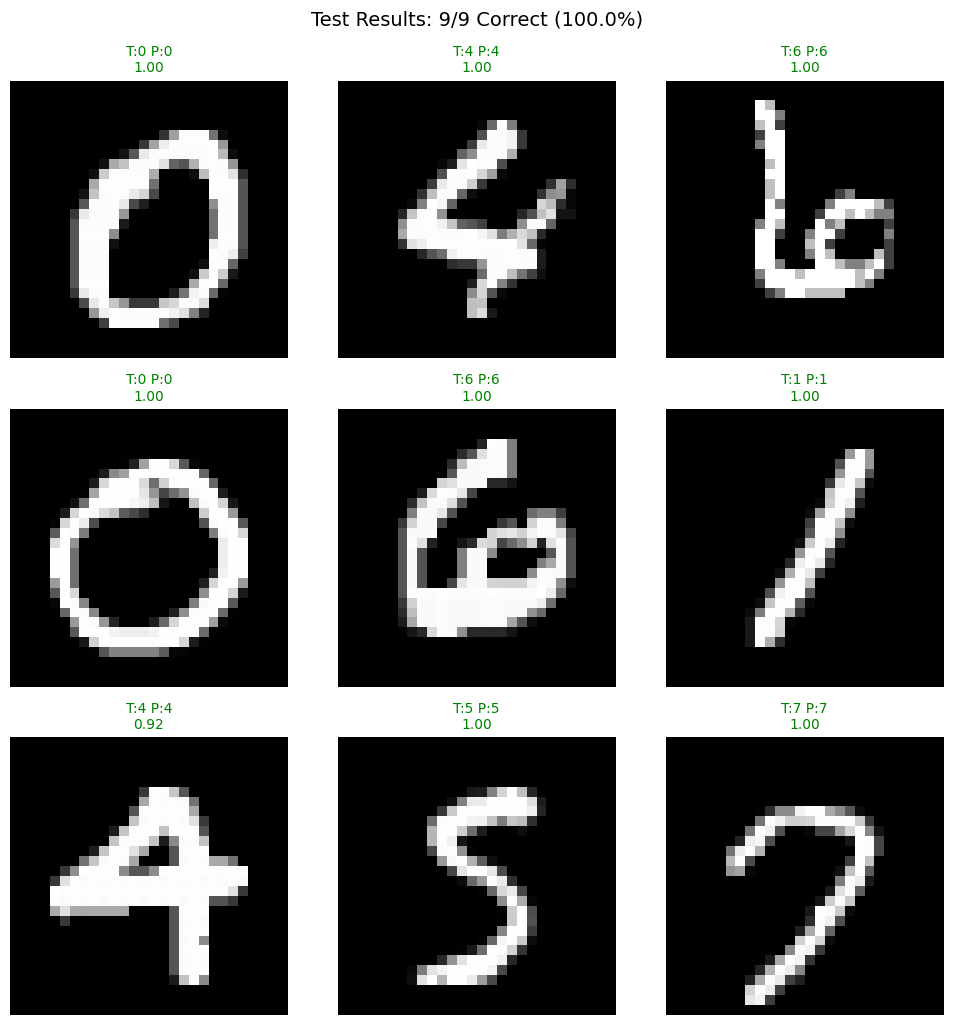

Accuracy: 9/9 = 100.0%


In [33]:
print("Testing Multiple Images")
test_multiple_images(9)